In [1]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
import torch

In [15]:

import torch
from torch import nn

class OutputAdapterPatch():

    def __init__(self, *args, vae_channel, last_dim=320, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_in = nn.Conv2d(in_channels=last_dim, out_channels=last_dim, kernel_size=3, stride=1, padding=1)

        self.res_block = nn.Sequential(
            nn.GroupNorm(num_groups=32, num_channels=last_dim),
            nn.SiLU(),
            nn.Conv2d(in_channels=last_dim, out_channels=last_dim, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=last_dim),
            nn.SiLU(),
            nn.Conv2d(in_channels=last_dim, out_channels=last_dim, kernel_size=3, stride=1, padding=1),
        )

        self.conv_out = nn.Sequential(
            nn.GroupNorm(num_groups=32, num_channels=last_dim),
            nn.SiLU(),
            nn.Conv2d(in_channels=last_dim, out_channels=vae_channel, kernel_size=3, stride=1, padding=1),
        )
    def post_forward(self, x):
        
        residual = self.conv_in(x)
        x = self.res_block(x)
        x = x + residual 
        x = self.conv_out(x) 
        return x

In [16]:
md = OutputAdapterPatch(vae_channel=64)

In [18]:
md.post_forward(torch.Tensor(1,320,64,64)).shape

torch.Size([1, 64, 64, 64])

In [2]:
noisy_latents = torch.Tensor(40, 64, 64, 64).cuda()
timesteps = torch.Tensor([615, 678, 556,  34, 389, 288,  84, 299, 459, 916, 660, 135, 903, 818,
        978, 724, 331, 354, 636, 679, 211, 213, 288, 469, 964, 393, 515, 459,
         61, 691, 939, 205, 163, 692, 900, 784, 395, 612, 445, 586]).long().cuda()
encoder_hidden_states = torch.Tensor(40, 77, 768).cuda()

In [5]:
unet = UNet2DConditionModel.from_pretrained(
            'deepghs/animefull-latest', subfolder="unet", low_cpu_mem_usage=False, ignore_mismatched_sizes=True, in_channels=64, out_channels=64
        ).cuda()

Some weights of UNet2DConditionModel were not initialized from the model checkpoint at deepghs/animefull-latest and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 64, 3, 3]) in the model instantiated
- conv_out.weight: found shape torch.Size([4, 320, 3, 3]) in the checkpoint and torch.Size([64, 320, 3, 3]) in the model instantiated
- conv_out.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([64]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1, stride=1, padding=1)(torch.Tensor(3,3,64,64)).shape

torch.Size([3, 64, 66, 66])

In [4]:
unet(noisy_latents, timesteps, encoder_hidden_states).sample.shape

torch.Size([40, 1, 64, 64])

In [7]:
import torch
import torch.nn as nn

class ImageAdapter(nn.Module):
    def __init__(self, in_channels, adapter_channels):
        super(ImageAdapter, self).__init__()
        self.adapter = nn.Sequential(
            nn.Conv2d(in_channels, adapter_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(adapter_channels, in_channels, kernel_size=1)
        )

    def forward(self, x):
        return x + self.adapter(x)

# Example usage
in_channels = 64  # Assuming RGB images, adjust as needed
adapter_channels = 64

# Create an image adapter
image_adapter = ImageAdapter(in_channels, adapter_channels)

# Example input tensor (batch size, channels, height, width)
input_tensor = torch.randn(4, in_channels, 64, 64)

# Apply the image adapter to the input tensor
image_adapter(input_tensor).shape

torch.Size([4, 64, 64, 64])

In [28]:
from movqgan.util import instantiate_from_config
from movqgan import get_movqgan_model
from omegaconf import OmegaConf
import torch
config = OmegaConf.load(f"./vae/vaegan.yaml")
model = instantiate_from_config(config['model'])# Initialize data loaders
ckpt_path = f"./vae/ckpt/step=13499-model.ckpt"
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['state_dict'])
vae = model.cuda()

Working with z of shape (1, 64, 32, 32) = 65536 dimensions.
loaded pretrained LPIPS loss from movqgan/modules/losses/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
use_ema = True


In [35]:
vae.decode(torch.Tensor(1, 64, 96, 64).cuda(),torch.Tensor(1, 64, 96, 64).cuda())[0].shape

torch.Size([1, 3, 768, 512])

In [12]:
from hcpdiff.utils.pipe_hook import HookPipe_T2I, HookPipe_I2I, HookPipe_Inpaint
from hcpdiff.utils.net_utils import to_cpu, to_cuda, auto_tokenizer, auto_text_encoder
import torch
pretrained_model = "stablediffusionapi/anything-v5"
HookPipe_T2I

hcpdiff.utils.pipe_hook.HookPipe_T2I

In [13]:
pipeline = HookPipe_T2I
te = auto_text_encoder(pretrained_model).from_pretrained(pretrained_model, subfolder="text_encoder")
tokenizer = auto_tokenizer(pretrained_model).from_pretrained(pretrained_model, subfolder="tokenizer", use_fast=False)
pipe = pipeline.from_pretrained(pretrained_model, safety_checker=None, requires_safety_checker=False,
                                text_encoder=te, tokenizer=tokenizer)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/linjw/anaconda3/envs/innoverse/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [27]:
pipe.vae.decode(torch.Tensor(1, 4, 96, 64),return_dict=False)[0].shape

torch.Size([1, 3, 768, 512])

In [47]:
pipe.vae.decode(torch.Tensor(1, 4, 96, 64),return_dict=False)[0]

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]],
       grad_fn=<ConvolutionBackward0>)

In [37]:
type(pipe.vae.decode(torch.Tensor(1, 4, 96, 64),return_dict=True))

diffusers.models.vae.DecoderOutput

In [44]:
type(pipe.vae.decode(torch.Tensor(1, 4, 96, 64)))

diffusers.models.vae.DecoderOutput

In [43]:
import diffusers
diffusers.models.vae.DecoderOutput(sample = torch.Tensor(1, 4, 96, 64))

DecoderOutput(sample=tensor([[[[-6.0997e-17,  1.4013e-45, -5.3636e+03,  ...,  1.5588e-01,
            1.5588e-01,  1.5588e-01],
          [ 1.5588e-01,  1.5588e-01,         nan,  ...,  1.5588e-01,
                   nan,  1.5588e-01],
          [ 1.5588e-01,  1.5588e-01,  1.5588e-01,  ...,  1.5588e-01,
            1.5588e-01,  1.5588e-01],
          ...,
          [ 1.5588e-01,  1.5588e-01,  1.5588e-01,  ...,  1.5588e-01,
            1.5588e-01,  1.5588e-01],
          [ 1.5588e-01,  1.5588e-01,  1.5588e-01,  ...,  1.5588e-01,
            1.5588e-01,  1.5588e-01],
          [ 1.5588e-01,  1.5588e-01,  1.5588e-01,  ...,  1.5588e-01,
            1.5588e-01,  1.5588e-01]],

         [[ 9.3767e+02, -8.2520e-02, -8.2520e-02,  ..., -8.2520e-02,
           -8.2520e-02, -8.2520e-02],
          [-8.2520e-02, -8.2520e-02,         nan,  ..., -8.2520e-02,
                   nan, -8.2520e-02],
          [-8.2520e-02, -8.2520e-02, -8.2520e-02,  ..., -8.2520e-02,
           -8.2520e-02, -8.2520e-02],

In [21]:
import argparse
import sys
import torch
from torch import nn

import colossalai
import colossalai.tensor
from colossalai.legacy.context.parallel_mode import ParallelMode
from colossalai.legacy.core import global_context as gpc
# from colossalai.utils import get_static_torch_model
from colossalai.utils import get_current_device
from colossalai.legacy.zero.gemini.colo_init_context import ColoInitContext
from colossalai.utils.model.colo_init_context import _convert_to_coloparam
from colossalai.tensor import ColoParameter

from hcpdiff.train_ac import Trainer, get_scheduler, ModelEMA
from diffusers import UNet2DConditionModel
from hcpdiff.utils.colo_utils import gemini_zero_dpp, GeminiAdamOptimizerP
from hcpdiff.utils.utils import load_config_with_cli
from hcpdiff.utils.net_utils import auto_text_encoder, TEUnetWrapper

ModuleNotFoundError: No module named 'colossalai.legacy.zero.gemini.colo_init_context'

In [27]:
colossalai.legacy.zero.gemini.ColoInitContext

AttributeError: module 'colossalai.legacy.zero.gemini' has no attribute 'ColoInitContext'

In [1]:
from torchvision import transforms
from PIL import Image

# 定义自定义的 transform 函数
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # 获取原始图像的宽和高
        width, height = img.size

        # 计算缩放比例
        scale = max(width, height) / max(self.target_size)

        # 计算缩放后的新尺寸
        new_width = int(width / scale)
        new_height = int(height / scale)

        # 缩放图像
        img = img.resize((new_width, new_height), Image.LANCZOS)

        # 创建一个白色背景的新图像
        new_img = Image.new("RGB", self.target_size, (255, 255, 255))

        # 将缩放后的图像粘贴到新图像中央
        offset = ((self.target_size[0] - new_width) // 2, (self.target_size[1] - new_height) // 2)
        new_img.paste(img, offset)

        return new_img

# 定义 transforms.Compose
transform = transforms.Compose([
    ResizeAndPad([512, 512]),
    transforms.ToTensor(),  # 转为 PyTorch 的 Tensor 格式
])

# 使用 transform 对图像进行预处理
img = Image.open("/home/linjw/Innoverse/HCP-Diffusion/imgs/CounterfeitV30_sample.jpeg")


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


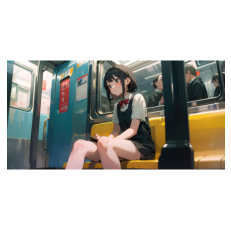

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
# 应用预处理
transformed_img = transform(img)

# 转为 NumPy 数组并反归一化
img_np = F.to_pil_image(transformed_img)
img_np = F.to_tensor(img_np)
img_np = img_np.numpy().transpose((1, 2, 0))

# 显示图像
plt.imshow(img_np)
plt.axis('off')
plt.show()
